In [44]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install ipywidgets
# %pip install opencv-python
# %pip install piqture
# %pip install qiskit_machine_learning==0.7.2
# %pip install tensorflow

In [1]:
import os
from IPython.display import clear_output
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from piqture.neural_networks.layers.convolutional_layer import QuantumConvolutionalLayer
from piqture.neural_networks.layers.pooling_layer import QuantumPoolingLayer2
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap
import torch
from PIL import Image

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [3]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

In [3]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [4]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

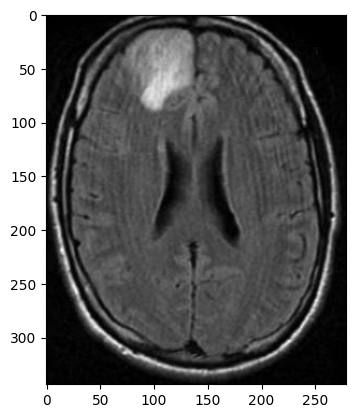

In [5]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y242.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

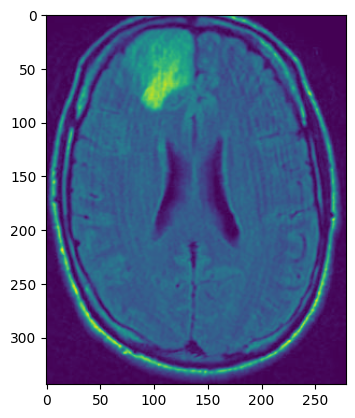

In [6]:
transform = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess the images

In [7]:
img_size = (128, 128)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

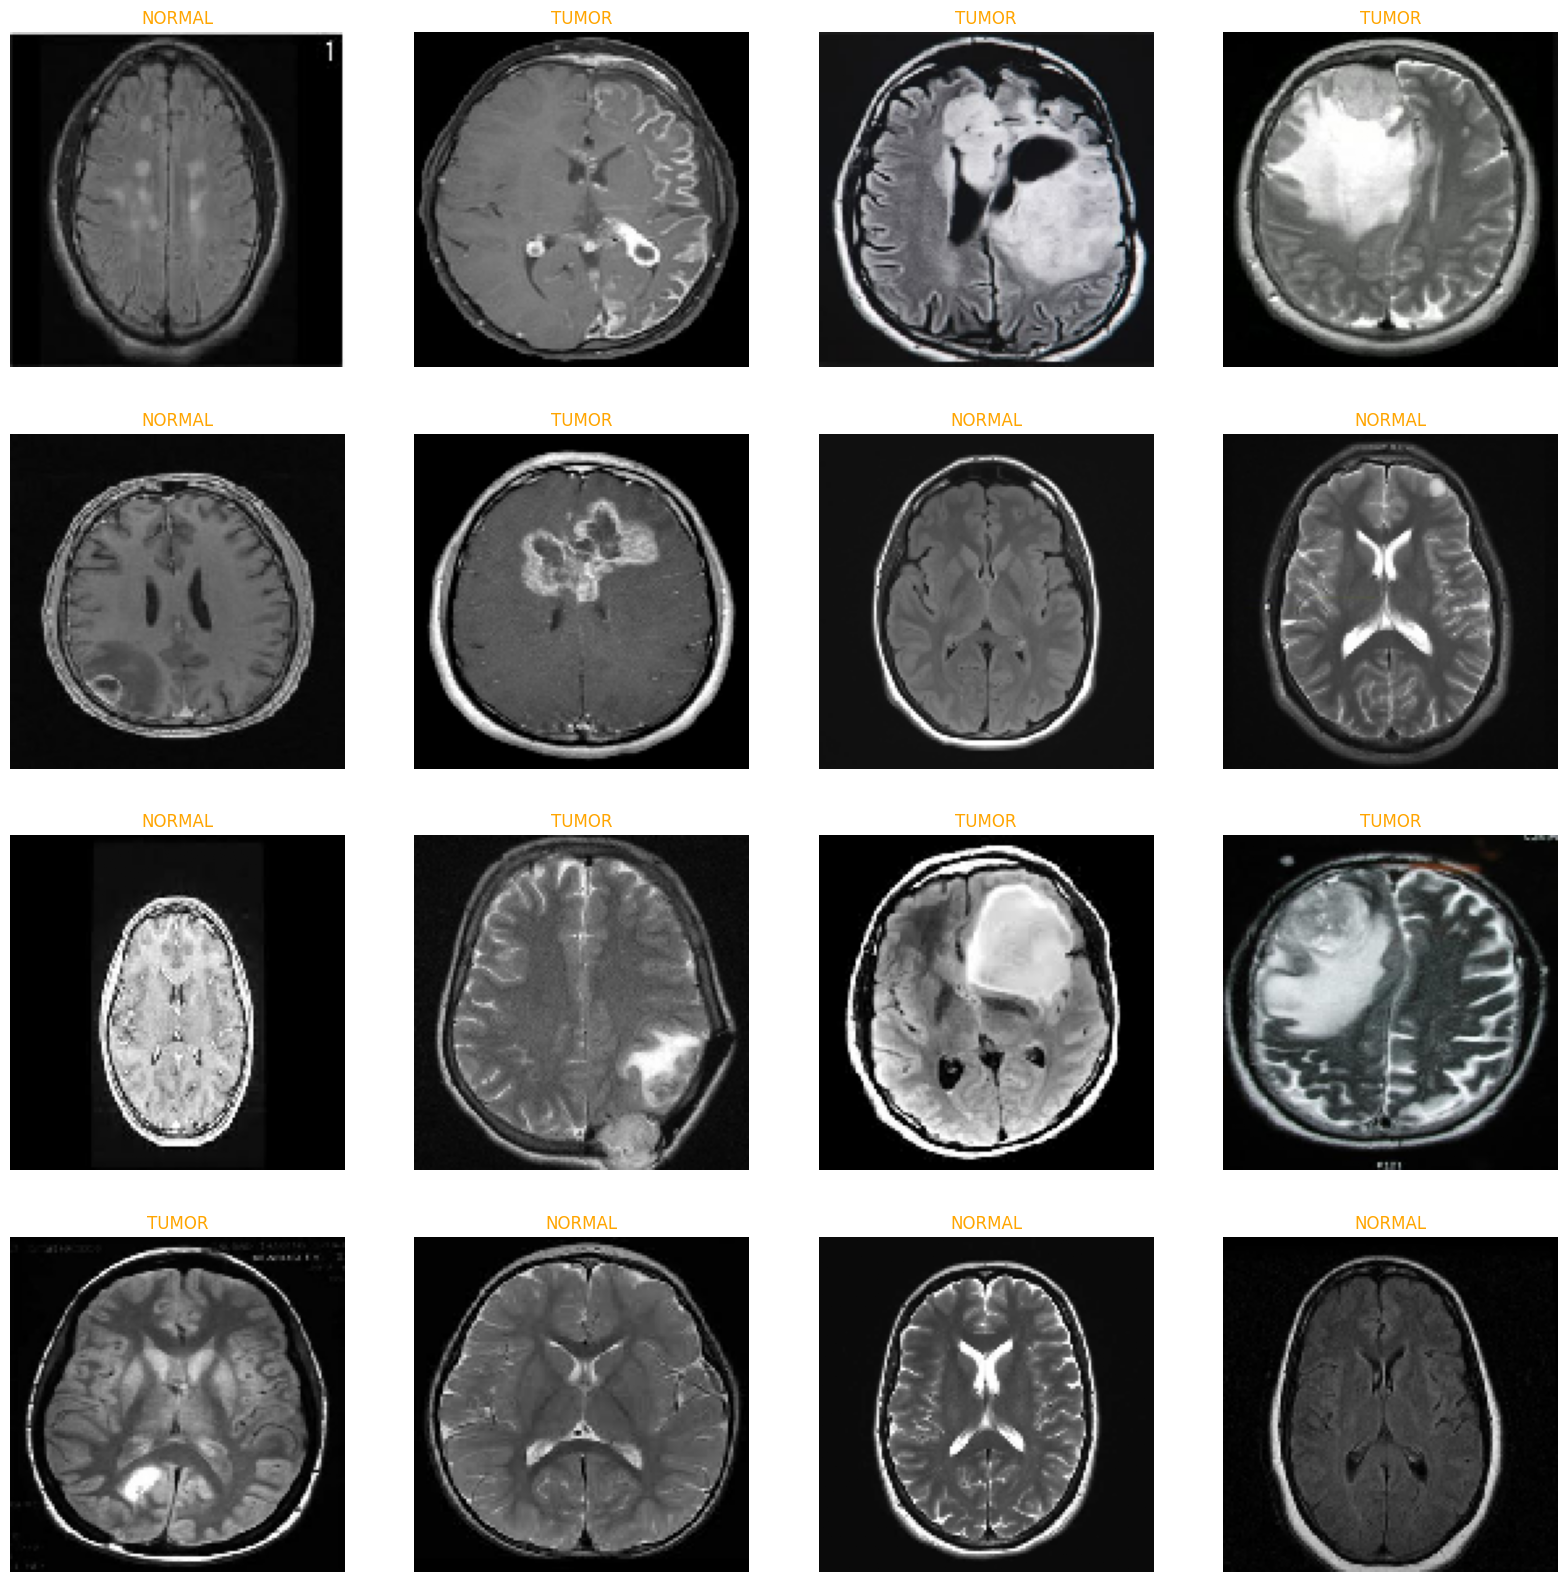

In [8]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'TUMOR': 0, 'NORMAL': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='orange', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [9]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=98)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=155)

all_data = np.concatenate([tumor_data, normal_data], axis=0)
all_labels = np.concatenate([tumor_labels, normal_labels], axis=0)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

X_train_res = X_train.reshape(X_train.shape[0], -1)
X_test_res = X_test.reshape(X_test.shape[0], -1)

In [10]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_res)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [12]:
X_test_pca = pca.transform(X_test_res)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Create & Visualize the QNN

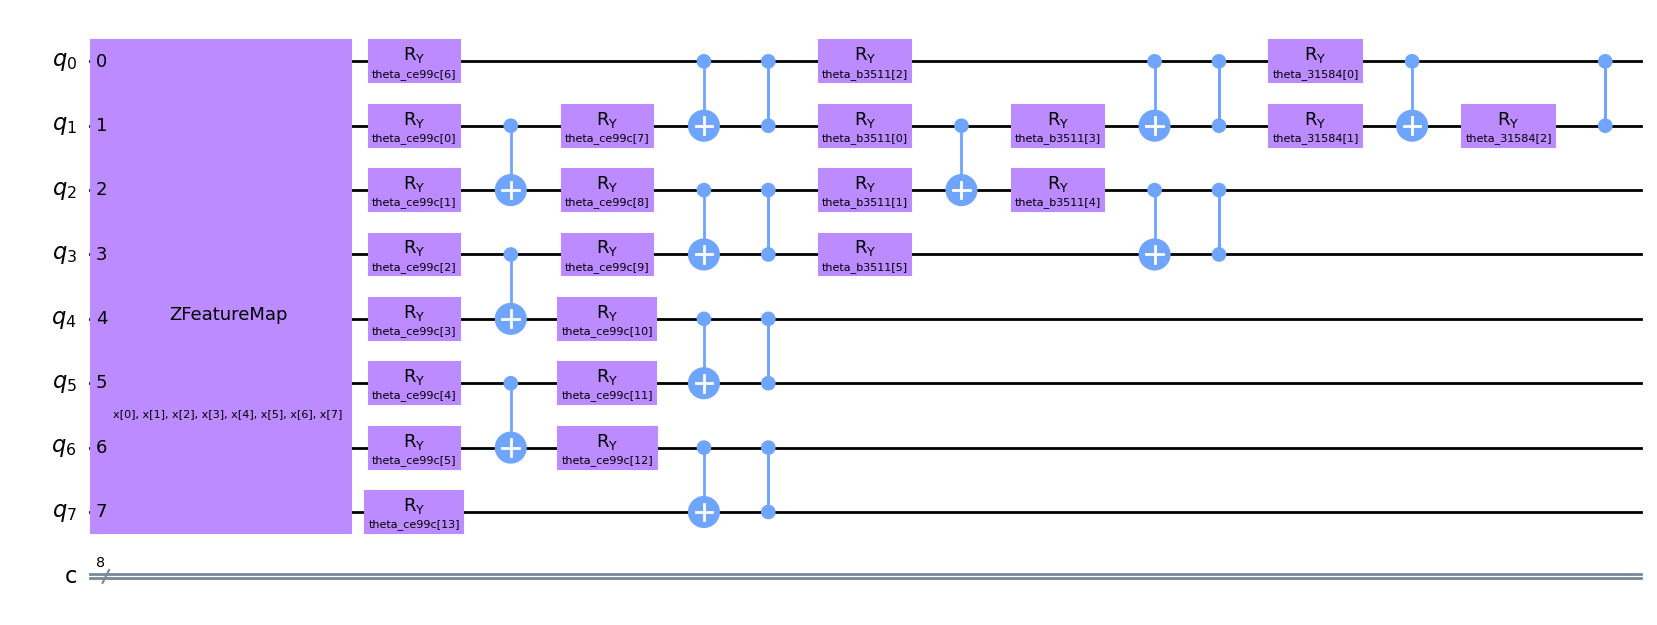

In [13]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

conv_layer1, _ = QuantumConvolutionalLayer(num_qubits=8).build_layer()
ansatz.compose(conv_layer1, list(range(8)), inplace=True)

pool_layer1, _ = QuantumPoolingLayer2(num_qubits=8, circuit=QuantumCircuit(8), unmeasured_bits=list(range(8))).build_layer()
ansatz.compose(pool_layer1, list(range(8)), inplace=True)

conv_layer2, _ = QuantumConvolutionalLayer(num_qubits=4).build_layer()
ansatz.compose(conv_layer2, list(range(4)), inplace=True)

pool_layer2, _ = QuantumPoolingLayer2(num_qubits=4, circuit=QuantumCircuit(4), unmeasured_bits=list(range(4))).build_layer()
ansatz.compose(pool_layer2, list(range(4)), inplace=True)

conv_layer3, _ = QuantumConvolutionalLayer(num_qubits=2).build_layer()
ansatz.compose(conv_layer3, list(range(2)), inplace=True)

pool_layer3, _ = QuantumPoolingLayer2(num_qubits=2, circuit=QuantumCircuit(2), unmeasured_bits=list(range(2))).build_layer()
ansatz.compose(pool_layer3, list(range(2)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl", style="clifford")

#### Objective function visualization

In [14]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#### Train with COBYLA optimizer

In [15]:
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=500),
    loss='cross_entropy',
    callback=callback_graph,
)

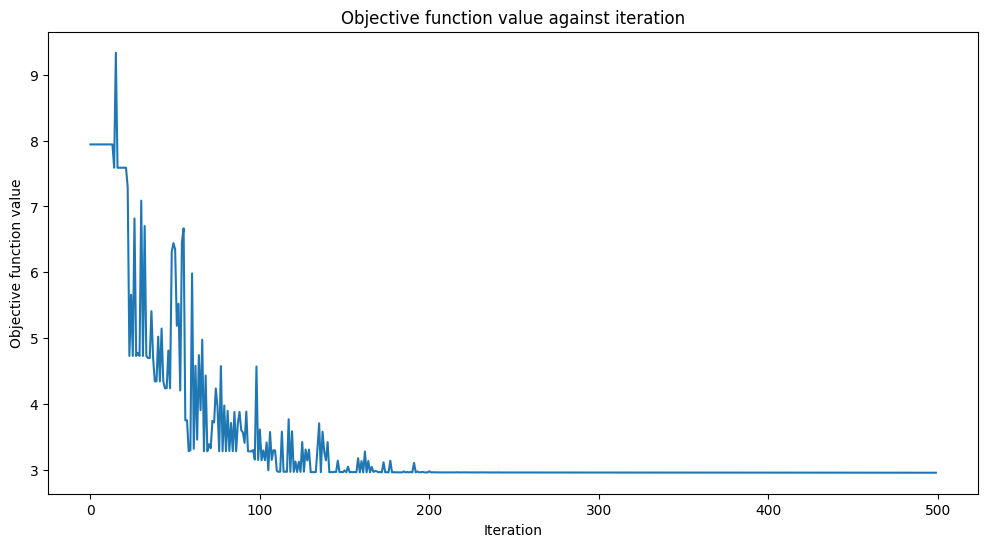

In [16]:
objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train_tensor, y_train_tensor)

#### Save model

In [17]:
classifier.save('models/NeuralNetworkClassifier_piqture_brain_tumor.model')

#### Load model

In [18]:
loaded_model = classifier.load('models/NeuralNetworkClassifier_piqture_brain_tumor.model')

In [19]:
train_accuracy = np.round(100 * classifier.score(X_train_tensor, y_train_tensor), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")
test_accuracy = np.round(100 * classifier.score(X_test_tensor, y_test_tensor), 2)
print(f"Accuracy from the test data: {test_accuracy}%")
predictions = classifier.predict(X_test_tensor)
print("***************************************************")
accuracy = np.mean(predictions == y_test_tensor.numpy())
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy from the training data: 43.59%
***************************************************
Accuracy from the test data: 47.5%
***************************************************
Accuracy: 44.62%


In [22]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright